1. IMPORT REQUIRED LIBRARIES

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc

import warnings
warnings.filterwarnings("ignore")


2. LOAD DATASET

In [ ]:
df = pd.read_csv("creditcard.csv")


Convert raw seconds into human-readable form

In [ ]:
# Convert Time (seconds) → Hour of Day (0–23 as integers)
df['Hour'] = ((df['Time'] // 3600) % 24).astype(int)


3. DATASET VALIDATION

In [ ]:
df.info()
df.isnull().sum()
df['Class'].value_counts()
df['Class'].value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122881 entries, 0 to 122880
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    122881 non-null  int64  
 1   V1      122881 non-null  float64
 2   V2      122881 non-null  float64
 3   V3      122881 non-null  float64
 4   V4      122881 non-null  float64
 5   V5      122881 non-null  float64
 6   V6      122881 non-null  float64
 7   V7      122881 non-null  float64
 8   V8      122881 non-null  float64
 9   V9      122881 non-null  float64
 10  V10     122880 non-null  float64
 11  V11     122880 non-null  float64
 12  V12     122880 non-null  float64
 13  V13     122880 non-null  float64
 14  V14     122880 non-null  float64
 15  V15     122880 non-null  float64
 16  V16     122880 non-null  float64
 17  V17     122880 non-null  float64
 18  V18     122880 non-null  float64
 19  V19     122880 non-null  float64
 20  V20     122880 non-null  float64
 21  V21     12

,proportion
Class,
0.0,0.997965
1.0,0.002035


In [ ]:
# Count of Legit and Fraud transactions
transaction_counts = df['Class'].value_counts()

print("Transaction Counts:")
print(transaction_counts)


Transaction Counts:
Class
0.0    122630
1.0       250
Name: count, dtype: int64


In [ ]:
# Percentage distribution
transaction_percent = df['Class'].value_counts(normalize=True) * 100

print("\nTransaction Percentage (%):")
print(transaction_percent.round(3))



Transaction Percentage (%):
Class
0.0    99.797
1.0     0.203
Name: proportion, dtype: float64


5. EDA – CLASS IMBALANCE


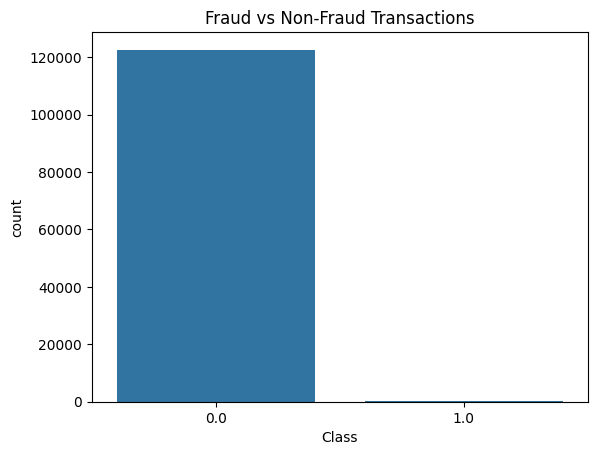

In [ ]:
sns.countplot(x='Class', data=df)
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()


6. EDA – FRAUD TIME PATTERNS
    To Identify risky hours

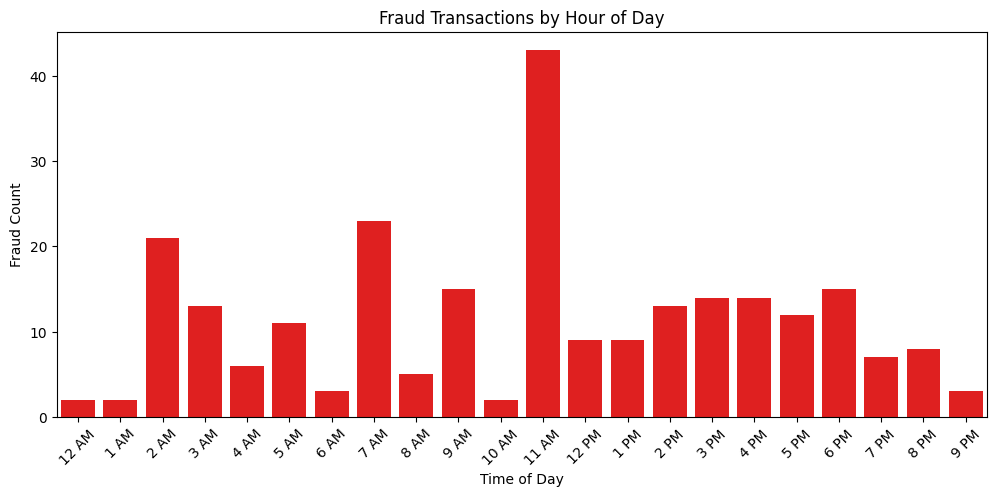

In [ ]:
# Create readable hour labels
hour_labels = [
    '12 AM','1 AM','2 AM','3 AM','4 AM','5 AM',
    '6 AM','7 AM','8 AM','9 AM','10 AM','11 AM',
    '12 PM','1 PM','2 PM','3 PM','4 PM','5 PM',
    '6 PM','7 PM','8 PM','9 PM','10 PM','11 PM'
]

plt.figure(figsize=(12,5))
ax = sns.countplot(
    x='Hour',
    data=df[df['Class'] == 1],
    color='red'
)

ax.set_xticklabels(hour_labels, rotation=45)
plt.title("Fraud Transactions by Hour of Day")
plt.xlabel("Time of Day")
plt.ylabel("Fraud Count")
plt.show()


Compare fraud vs legit spending

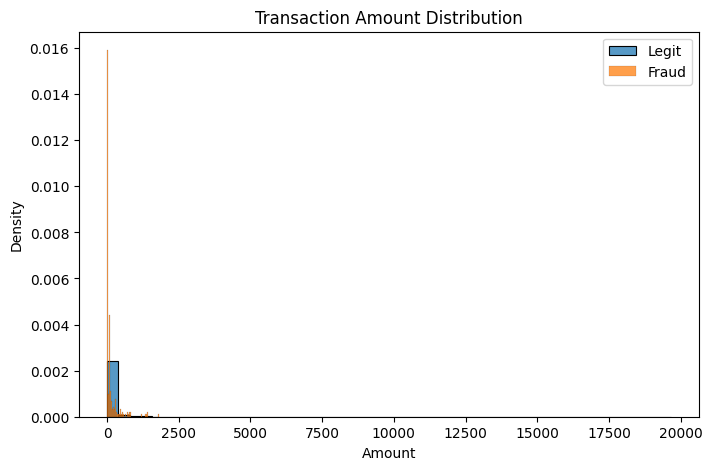

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df[df['Class']==0]['Amount'], bins=50, label='Legit', stat='density')
sns.histplot(df[df['Class']==1]['Amount'], bins=50, label='Fraud', stat='density')
plt.legend()
plt.title("Transaction Amount Distribution")
plt.show()


8. DATA PREPROCESSING

In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']


Scale Amount

In [ ]:
scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X[['Amount']])


9. HANDLLING MISSING TARGET VALUES

In [ ]:
df = df.dropna(subset=['Class'])
X = df.drop('Class', axis=1)
y = df['Class']


10. TRAIN–TEST SPLIT

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


11. MODEL TRAINING FRAUD RISK SCORING

In [ ]:
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

12. FRAUD PROBABILITY PREDICTION

In [ ]:
fraud_scores = model.predict_proba(X_test)[:, 1]
print(fraud_scores)

[0.0089823  0.02578475 0.03704594 ... 0.02744797 0.15550724 0.05822025]


3. MODEL EVALUATION (AUPRC)

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, fraud_scores)
auprc = auc(recall, precision)
print("AUPRC Score:", auprc)


AUPRC Score: 0.7089008583144922


In [ ]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0]
})
feature_importance['abs_coeff'] = feature_importance['coefficient'].abs()
feature_importance.sort_values(by='abs_coeff', ascending=False).head(10)


,feature,coefficient,abs_coeff
22,V22,1.505984,1.505984
10,V10,-1.157309,1.157309
14,V14,-1.154528,1.154528
12,V12,-0.943105,0.943105
16,V16,-0.916293,0.916293
4,V4,0.896433,0.896433
21,V21,0.757784,0.757784
8,V8,-0.732589,0.732589
17,V17,-0.676844,0.676844
9,V9,-0.593154,0.593154


15. SINGLE TRANSACTION EXPLANATION

In [ ]:
#To explain why a transaction is Risky

In [ ]:
def explain_transaction(row, top_n=3):
    contributions = row * model.coef_[0]
    explanation = pd.DataFrame({
        'feature': X.columns,
        'contribution': contributions
    })
    explanation['abs_contribution'] = explanation['contribution'].abs()
    explanation = explanation.sort_values(by='abs_contribution', ascending=False)
    return explanation.head(top_n)['feature'].tolist()


Fraud prevention(FINAL GOAL)

In [ ]:
def transaction_decision(fraud_score, amount):
    if fraud_score >= 0.85:
        return "BLOCK"
    elif fraud_score >= 0.60 or amount > 2:
        return "ASK OTP"
    else:
        return "ALLOW"


In [ ]:
# IMPORTANT: double brackets [[ ]] — this creates a DataFrame
sample_txn = df.loc[df['Class'] == 1].head(1)

type(sample_txn)



pandas.core.frame.DataFrame

In [ ]:
sample_input = sample_txn.drop(columns=['Class'])

type(sample_input)


pandas.core.frame.DataFrame

In [ ]:
sample_input = sample_input[X.columns]


In [ ]:
sample_input.loc[:, ['Amount']] = scaler.transform(
    sample_input.loc[:, ['Amount']]
)


In [ ]:
sample_input.shape


(1, 31)

In [ ]:
fraud_score = model.predict_proba(sample_input)[0][1]
fraud_score


np.float64(0.9999988678989724)

In [ ]:
decision = transaction_decision(
    fraud_score,
    sample_input['Amount'].iloc[0]
)
decision


'BLOCK'

In [ ]:
reasons = explain_transaction(sample_input.iloc[0])
reasons


['V14', 'V4', 'V10']

In [ ]:
output = {
    "fraud_score": round(float(fraud_score), 2),
    "decision": decision,
    "reason": reasons
}

output


{'fraud_score': 1.0, 'decision': 'BLOCK', 'reason': ['V14', 'V4', 'V10']}

ASK OTP (Medium Risk Transaction)

In [ ]:
# -------- OTP CASE --------
sample_otp = df[
    (df['Class'] == 0) &
    (df['Amount'] > df['Amount'].quantile(0.95))
].head(1)

sample_otp_input = sample_otp.drop(columns=['Class'])
sample_otp_input = sample_otp_input[X.columns]

sample_otp_input.loc[:, ['Amount']] = scaler.transform(
    sample_otp_input.loc[:, ['Amount']]
)

fraud_score_otp = model.predict_proba(sample_otp_input)[0][1]
decision_otp = transaction_decision(
    fraud_score_otp,
    sample_otp_input['Amount'].iloc[0]
)

reasons_otp = explain_transaction(sample_otp_input.iloc[0])

otp_output = {
    "fraud_score": round(float(fraud_score_otp), 2),
    "decision": decision_otp,
    "reason": reasons_otp
}

otp_output


{'fraud_score': 1.0, 'decision': 'BLOCK', 'reason': ['V4', 'V7', 'V8']}

ALLOW TRANSACTION (Low Risk)

In [ ]:
# -------- ALLOW CASE --------
sample_allow = df[
    (df['Class'] == 0) &
    (df['Amount'] < df['Amount'].quantile(0.50))
].head(1)

sample_allow_input = sample_allow.drop(columns=['Class'])
sample_allow_input = sample_allow_input[X.columns]

sample_allow_input.loc[:, ['Amount']] = scaler.transform(
    sample_allow_input.loc[:, ['Amount']]
)

fraud_score_allow = model.predict_proba(sample_allow_input)[0][1]
decision_allow = transaction_decision(
    fraud_score_allow,
    sample_allow_input['Amount'].iloc[0]
)

reasons_allow = explain_transaction(sample_allow_input.iloc[0])

allow_output = {
    "fraud_score": round(float(fraud_score_allow), 2),
    "decision": decision_allow,
    "reason": reasons_allow
}

allow_output


{'fraud_score': 0.02, 'decision': 'ALLOW', 'reason': ['V12', 'V22', 'V16']}

Manually Taking Transaction

In [ ]:

# REUSABLE FRAUD DECISION FUNCTION

def predict_transaction_decision(
    transaction_df,
    model,
    scaler,
    feature_columns,
    decision_fn,
    explain_fn
):
    """
    Input:
    - transaction_df : DataFrame with ONE transaction (no Class column)
    - model           : trained ML model
    - scaler          : fitted StandardScaler
    - feature_columns : X.columns used during training
    - decision_fn     : transaction_decision function
    - explain_fn      : explain_transaction function

    Output:
    - Dictionary with fraud_score, decision, and explanation
    """

    # Ensure correct column order
    txn = transaction_df[feature_columns].copy()

    # Scale Amount (same as training)
    txn.loc[:, ['Amount']] = scaler.transform(txn.loc[:, ['Amount']])

    # Predict fraud probability
    fraud_score = model.predict_proba(txn)[0][1]

    # Apply business rules
    decision = decision_fn(
        fraud_score,
        txn['Amount'].iloc[0]
    )

    # Explain decision
    reasons = explain_fn(txn.iloc[0])

    return {
        "fraud_score": round(float(fraud_score), 2),
        "decision": decision,
        "reason": reasons
    }


SINGLE DEMO CELL (ALLOW / OTP / BLOCK)

In [ ]:
# ==========================================
# SINGLE DEMO CELL: REAL-TIME SIMULATION
# ==========================================

# --- BASE TRANSACTION (LEGIT) ---
base_txn = df[df['Class'] == 0].head(1).copy()
base_txn = base_txn.drop(columns=['Class'])

# ---------- BLOCK CASE ----------
block_txn = base_txn.copy()
block_txn['Amount'] = df['Amount'].quantile(0.99)  # very high amount
block_txn['Hour'] = 2                               # 2 AM

block_result = predict_transaction_decision(
    block_txn,
    model,
    scaler,
    X.columns,
    transaction_decision,
    explain_transaction
)

# ---------- OTP CASE ----------
otp_txn = base_txn.copy()
otp_txn['Amount'] = df['Amount'].quantile(0.95)    # moderately high
otp_txn['Hour'] = 10                                # daytime

otp_result = predict_transaction_decision(
    otp_txn,
    model,
    scaler,
    X.columns,
    transaction_decision,
    explain_transaction
)

# ---------- ALLOW CASE ----------
allow_txn = base_txn.copy()
allow_txn['Amount'] = df['Amount'].quantile(0.20)  # low amount
allow_txn['Hour'] = 14                              # 2 PM

allow_result = predict_transaction_decision(
    allow_txn,
    model,
    scaler,
    X.columns,
    transaction_decision,
    explain_transaction
)

# -------- DISPLAY RESULTS --------
print("BLOCK CASE OUTPUT:\n", block_result, "\n")
print("OTP CASE OUTPUT:\n", otp_result, "\n")
print("ALLOW CASE OUTPUT:\n", allow_result)


BLOCK CASE OUTPUT:
 {'fraud_score': 0.28, 'decision': 'ASK OTP', 'reason': ['V4', 'V3', 'V12']} 

OTP CASE OUTPUT:
 {'fraud_score': 0.65, 'decision': 'ASK OTP', 'reason': ['Hour', 'V4', 'V3']} 

ALLOW CASE OUTPUT:
 {'fraud_score': 0.8, 'decision': 'ASK OTP', 'reason': ['Hour', 'V4', 'V3']}


Reusable fuction

In [ ]:
# Take any unseen transaction as new input
new_txn = df.sample(1).drop(columns=['Class'])

# Use reusable function
result = predict_transaction_decision(
    new_txn,
    model,
    scaler,
    X.columns,
    transaction_decision,
    explain_transaction
)
print("LIVE TRANSACTION RESULT")
print("-----------------------")
result


LIVE TRANSACTION RESULT
-----------------------


{'fraud_score': 0.15, 'decision': 'ALLOW', 'reason': ['Time', 'Hour', 'V4']}